# Implementation of Finite Mixture Model

<details>
  <summary>Table of Contents</summary>
  <ol>
    <li>
      Import Needed Filepaths and Libraries
    </li>
    <li>
    Load Dataset Into Pandas DataFrame
    </li>
    <li>
    Define Response Variable `y`
    </li>
    <li>
    Set Up Reproducible Random Number Generator
    </li>
    <li>
      Setting Up Mixture Model
      <ul>
        <li>Initial Parameters</li>
        <li>Setting Priors</li>
      </ul>
    </li>
    <li>Gibbs Sampler Implementation
      <ul>
        <li>Gibbs Sampler Updates</li>
      </ul>
</li>
  </ol>
</details>

The beauty of Bayesian techniques over other data science techniques is that many data points are not required. Our objective is to model the distribution of .

$y_{i}$. $z_{i}$ is our indicator variable that indicates what type. If it's zero, then, and if it's one, then. Lambda is the mixing portion. It's what percent of are versus.

## Import Needed Filepaths and Libraries

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from texas_gerrymandering_hb4.config import FINAL_CSV

## Load Dataset Into Pandas DataFrame
Our processed dataset is read into a Pandas DataFrame.

In [25]:
df = pd.read_csv(FINAL_CSV)

## Prepare Outcomes

### Defining Response Variable `y`
* `y` represents the Democratic vote share per district.

In [26]:
y = df["dem_share"].values.astype(float)

### Defining Sample Size
* `n` denotes the sample size, which is the number of Congressional districts in Texas (38).

In [27]:
n = len(y)

## Adding Racial Minority Composition Column to DataFrame
* These values will help interpret the mixture components in terms of race.

In [28]:
df["pct_minority"] = 1 - df["pct_white"]

## Setting Up Mixture Model

### Set Up Reproducible Random Number Generator

In [29]:
np.random.seed(123)

### Initial Parameters
* These parameters represent starting guesses for the Gibbs sampler.
* `sigma_squared_1` and `sigma_squared_2` are the initial variances for each component.

#### Initialize $\lambda$
`lambda` ($\lambda$) is the mixing proportion. Starting from a place of ignorance, we assume a perfect mix between the two, and that our means are the sample means and our variances are the sample variances. $\lambda$ is set to 0.5 to serve as a neutral initial guess.

In [30]:
_lambda = 0.5

#### Initialize Means: $\mu_1$ and $\mu_2$
* `mu_1` and `mu_2` represent the initial means for each component.

In [31]:
mu_1 = np.mean(y)
mu_2 = np.mean(y)

#### Initialize Variances: $\sigma^2_1$ and $\sigma^2_2$
* `sigma_squared_1` and `sigma_squared_2` are the initial variances for each component.

In [32]:
sigma_squared_1 = np.var(y,ddof=1)
sigma_squared_2 = np.var(y, ddof=1)

### Setting Priors
* Our variances are coming from the scaled inverse-$\chi^2$ distribution with 2 degrees of freedom.

#### Setting Priors for $\lambda$: $\alpha_1$ and $\alpha_2$
* `alpha_1` and `alpha_2` are the priors for lambda.
$$\lambda \sim Beta(\alpha_2, \alpha_2)$$
Because the prior for lambda is Beta(2,2), `alpha_1` and `alpha_2` are both set to 2.
* This is a conjugate prior. Also, as a reminder, Beta(2,2) is also a Dirchilet distribution. What is beneficial about this is that the probability of obtaining 0 or 1, which is a degenerate model, is 0. Hence, as you get closer to 0 or 1, the likelihood is tiny. As a result, the problem is pushed further away from a degenerate value, so they become less likely to accidently become a point of convergence.

In [33]:
alpha_1 = 2
alpha_2 = 2

#### Setting Priors for Means: $\mu_1$ and $\mu_2$
* The means `m0_1` and `mu0_2` are coming from the same distribution.

In [34]:
mu0_1 = np.mean(y)
mu0_2 = np.mean(y)

#### Setting Priors for Variances: $\sigma_1^2$ and $\sigma_2^2$

In [35]:
sigma_0_squared_1 = 0.20**2
sigma_0_squared_2 = 0.20**2

#### Setting Priors for Degrees of Freedom

In [36]:
degrees_of_freedom0_1 = 2
degrees_of_freedom0_2 = 2

### Gibbs Sampler Parameters

In [37]:
iterations = 1000
warmup = 500

### Storage for Samples

In [38]:
lambda_samples = np.zeros(iterations)
mu1_samples = np.zeros(iterations)
mu2_samples = np.zeros(iterations)
sigma_squared_1_samples = np.zeros(iterations)
sigma_squared_2_samples = np.zeros(iterations)
z_samples = np.zeros((iterations, n), dtype=int)

## Scaled Inverse-$\chi^2$ Sampler
* This is the conjugate prior for the variance in the normal model.
* This will be used to update $\sigma_1^2$ and $\sigma_2^2$.

In [39]:
def rinvchisq(df, scale):
    return df * scale / np.random.chisquare(df)


## Gibbs Sampler Implementation
* The process for the Gibbs sampler involves initializing parameters, iterative sampling, and continuing the iterations until convergence.
* The benefits of the Gibbs sampler are that it handles complex, high-dimensional distributions and is easier to implement than direct sampling methods.

###  Gibbs Sampler Updates

#### Updating z
* We compute the posterior probability that our $z_{i}=1$, taking into account the normal distributions that our data follows:
$$p_{z_{i}=1} = \frac{\lambda_{old} \cdot N(y_{i}|\mu_{1,init}, \sigma^2_{1,init})}{\lambda_{old} \cdot N(y_{i}|\mu_{1,init}, \sigma_{1,init}^2) + (1-\lambda_{old})N(y_{i}|\mu_{1,init}, \sigma_{1,init}^2)}$$
* Once the probability of $z_{i=1}$ is computed, then a new value of $z_{i}$ is computed using a binomial distribution.
$$z_{i}^{new} \leftarrow Bin(n, p_{z_{i}=1})$$

#### Updating $\lambda$
* Updating $\lambda$ is a two-step process because it follows a Beta distribution.
* First, we update the Beta distribution using the standard form from conjugacy. Recall that our parameters are (2,2); they are being updated based on the frequency of 1's among our z's, which is why we end up with two updates for $\alpha$ and $\beta$. We begin updating $\lambda$ by first updating $\alpha$ and $\beta$ parameters:
$$\alpha_{new} \leftarrow \alpha_{old} + \sum z_{i}^{new}$$
$$\beta_{new} \leftarrow \beta_{old} + n -  \sum z_{i}^{new}$$
* We update $\lambda$ by computing the posterior probability. Because our $\lambda$ is coming from a Beta distribution with updated parameters, we draw a value of $\lambda$:
$$\lambda_{new} \leftarrow Beta(\alpha_{new}, \beta_{new})$$

#### Updating Means: $\mu_1$ and $\mu_2$
* Our number of observations are $n_1 = \sum z_{i}^{new}$ and $n_2 = \sum z_{i}^{new}$, respectively. Recall that our $z_{i}$ values have been redrawn.
* We examine the total number of observations, followed by the means.  We compute the means as follows:
$$\bar{y}_1 = \frac{1}{n_1} \sum y_{i} (z_{i}^{new} = 1)$$
$$\bar{y}_2 = \frac{1}{n_2} \sum y_{i} (z_{i}^{new} = 1)$$
* Once we obtain our means, we are able to compute a posterior mean based our sample. We construct this using our initial values; we use `init` to denote this. This is combined with our prior and sample to compute a new mean as follows:
$$\mu_{1,new} = \frac{\frac{\mu}{\sigma_{1,init}^2} + n_1 \frac{\bar{y}_1}{\sigma^2_{1, old}}}{\frac{1}{\sigma_{1,init}^2}}$$

#### Updating Variances: $\sigma_1^2$ and $\sigma_2^2$
* We compute the posterior distribution parameters for $\chi^2$(\alpha^2):
$$\alpha_{new}^2 \leftarrow \frac{\alpha_1^2 + n_1 s^2}{}$$

In [40]:
for i in range(iterations):
    # ---- Update z (component membership for each district) ----
    lik_1 = _lambda * norm.pdf(y, loc=mu_1, scale=np.sqrt(sigma_squared_1))
    lik_2 = (1 - _lambda) * norm.pdf(y, loc=mu_2, scale=np.sqrt(sigma_squared_2))
    z_probs = lik_1 / (lik_1 + lik_2)
    z = np.random.binomial(1, z_probs)  # 1 = component 1, 0 = component 2

    # ---- Update lambda ----
    alpha_lambda_post = alpha_1 + np.sum(z)
    beta_lambda_post = alpha_2 + (n - np.sum(z))
    _lambda = np.random.beta(alpha_lambda_post, beta_lambda_post)

    # ---- Update mu_1 ----
    n1 = np.sum(z)
    if n1 > 0:
        y1_mean = np.mean(y[z == 1])
        # *** FIXED: use sigma_squared_1 in BOTH places ***
        mu1_post_mean = ((mu0_1 / sigma_0_squared_1) + n1 * y1_mean / sigma_squared_1) / \
                        (1 / sigma_0_squared_1 + n1 / sigma_squared_1)
        mu1_post_sd = np.sqrt(1 / (1 / sigma_0_squared_1 + n1 / sigma_squared_1))
    else:
        mu1_post_mean = mu0_1
        mu1_post_sd = np.sqrt(sigma_0_squared_1)
    mu_1 = np.random.normal(mu1_post_mean, mu1_post_sd)

    # ---- Update mu_2 ----
    n2 = n - n1
    if n2 > 0:
        y2_mean = np.mean(y[z == 0])
        mu2_post_mean = ((mu0_2 / sigma_0_squared_2) + n2 * y2_mean / sigma_squared_2) / \
                        (1 / sigma_0_squared_2 + n2 / sigma_squared_2)
        mu2_post_sd = np.sqrt(1 / (1 / sigma_0_squared_2 + n2 / sigma_squared_2))
    else:
        mu2_post_mean = mu0_2
        mu2_post_sd = np.sqrt(sigma_0_squared_2)
    mu_2 = np.random.normal(mu2_post_mean, mu2_post_sd)

    # ---- Update sigma_1_sq (scaled inverse-chi-squared) ----
    nu1_post = degrees_of_freedom0_1 + n1
    if n1 > 0:
        ss1 = np.sum((y[z == 1] - mu_1) ** 2)
    else:
        ss1 = 0.0
    sigma1_post_scale = (degrees_of_freedom0_1 * sigma_0_squared_1 + ss1) / nu1_post
    sigma_1_sq = rinvchisq(nu1_post, sigma1_post_scale)

    # ---- Update sigma_2_sq (scaled inverse-chi-squared) ----
    nu2_post = degrees_of_freedom0_2 + n2
    if n2 > 0:
        ss2 = np.sum((y[z == 0] - mu_2) ** 2)
    else:
        ss2 = 0.0
    sigma2_post_scale = (degrees_of_freedom0_2 * sigma_0_squared_2 + ss2) / nu2_post
    sigma_2_sq = rinvchisq(nu2_post, sigma2_post_scale)

    # ---- IMPORTANT: feed σ² back into the state ----
    sigma_squared_1 = sigma_1_sq
    sigma_squared_2 = sigma_2_sq

    # ---- Store samples ----
    lambda_samples[i] = _lambda
    mu1_samples[i] = mu_1
    mu2_samples[i] = mu_2
    sigma_squared_1_samples[i] = sigma_1_sq
    sigma_squared_2_samples[i] = sigma_2_sq
    z_samples[i, :] = z



## Posterior Summaries

### Discard Warmup Draws

In [41]:
lambda_post = lambda_samples[warmup:]
mu1_post = mu1_samples[warmup:]
mu2_post = mu2_samples[warmup:]
sigma1_post = sigma_squared_1_samples[warmup:]
sigma2_post = sigma_squared_2_samples[warmup:]
z_post = z_samples[warmup:, :]

In [42]:
# For each iteration, define which component is the "low-dem-share" component.
# If mu1 < mu2 in that iteration, component 1 is "gerrymandered";
# otherwise component 0 is "gerrymandered".

is_low1 = mu1_post < mu2_post              # shape: (iterations - warmup,)
gerr_label_per_iter = np.where(is_low1, 1, 0)  # 1 if comp 1 is low-dem, 0 otherwise

# For each district i, posterior P(gerrymandered) =
# proportion of iterations where its z equals that iteration's "gerrymandered" label.
post_prob_gerrymandered = np.mean(
    z_post == gerr_label_per_iter[:, None],
    axis=0
)

df["post_prob_gerrymandered"] = post_prob_gerrymandered


### Calculate Means for Each Parameter

In [43]:
mean_lambda = lambda_post.mean()
mean_mu1 = mu1_post.mean()
mean_mu2 = mu2_post.mean()

### Print Posterior Means

In [44]:
print("Posterior mean lambda:", mean_lambda)
print("Posterior mean mu_1 (component 1):", mean_mu1)
print("Posterior mean mu_2 (component 2):", mean_mu2)

Posterior mean lambda: 0.5114306725007883
Posterior mean mu_1 (component 1): 0.4983882869425903
Posterior mean mu_2 (component 2): 0.49593575229907844


## Determining Which Components Have Low Democratic Vote Share

In [45]:
if mean_mu1 < mean_mu2:
    gerr_comp = 1
else:
    gerr_comp = 0

## Sort Districts by Probability of Being Gerrymandered

In [46]:
df_sorted = df.sort_values("post_prob_gerrymandered", ascending=False)

print("\nTop districts by posterior probability of being in the low-dem-share component:")
print(df_sorted[[
    "district_id",
    "dem_share",
    "rep_share",
    "pct_white",
    "pct_minority",
    "polsby_popper",
    "reock",
    "post_prob_gerrymandered"
]].head(10))


Top districts by posterior probability of being in the low-dem-share component:
    district_id  dem_share  rep_share  pct_white  pct_minority  polsby_popper  \
9            10   0.393264   0.583941   0.626595      0.373405       0.144847   
37           38   0.409810   0.565194   0.530450      0.469550       0.191635   
1             2   0.399379   0.577517   0.526751      0.473249       0.165232   
2             3   0.403698   0.573637   0.577914      0.422086       0.216761   
5             6   0.404557   0.571640   0.512241      0.487759       0.268900   
35           36   0.387174   0.590592   0.491224      0.508776       0.133533   
21           22   0.404133   0.569289   0.458585      0.541415       0.202273   
20           21   0.404610   0.573014   0.577278      0.422722       0.306337   
13           14   0.389740   0.587634   0.535507      0.464493       0.139885   
30           31   0.398484   0.575367   0.573229      0.426771       0.308996   

       reock  post_prob_ger

## Scatterplot

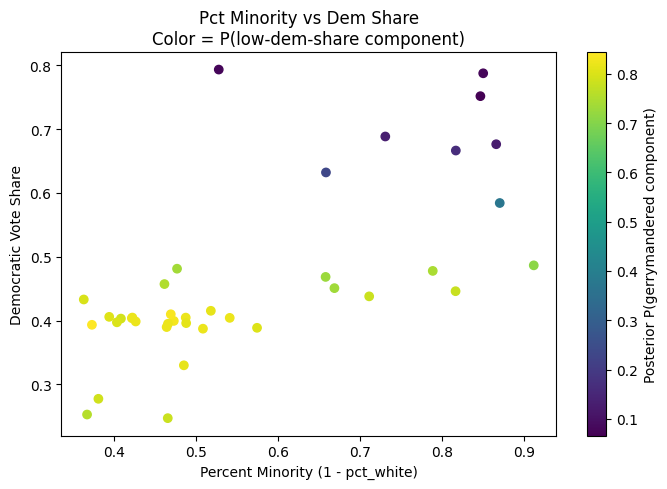

In [47]:
# Scatter: pct_minority vs dem_share, colored by prob gerrymandered
plt.figure(figsize=(7, 5))
sc = plt.scatter(
    df["pct_minority"],
    df["dem_share"],
    c=df["post_prob_gerrymandered"],
    cmap="viridis"
)
plt.colorbar(sc, label="Posterior P(gerrymandered component)")
plt.xlabel("Percent Minority (1 - pct_white)")
plt.ylabel("Democratic Vote Share")
plt.title("Pct Minority vs Dem Share\nColor = P(low-dem-share component)")
plt.tight_layout()
plt.show()


## Histogram of Components by Democratic Vote Share

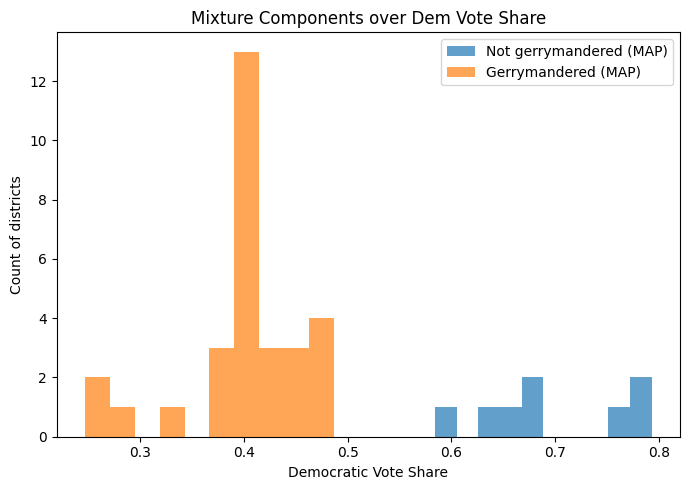

In [48]:
map_assign = (df["post_prob_gerrymandered"] > 0.5).astype(int)
plt.figure(figsize=(7, 5))
plt.hist(y[map_assign == 0], bins=10, alpha=0.7, label="Not gerrymandered (MAP)")
plt.hist(y[map_assign == 1], bins=10, alpha=0.7, label="Gerrymandered (MAP)")
plt.xlabel("Democratic Vote Share")
plt.ylabel("Count of districts")
plt.title("Mixture Components over Dem Vote Share")
plt.legend()
plt.tight_layout()
plt.show()
